<a href="https://colab.research.google.com/github/emrahyurtlu/Intro-to-tensorflow-for-deep-learning/blob/main/CMPE430/Lab_4_Getting_started_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CMPE430 LAB WEEK 4 - Getting started with neural networks**

11.11.2021 Thursday 14:30-16:20

Lab Assistant : Cansen Çağlayan (cansen.caglayan@atilim.edu.tr)

**References**

Book : Deep Learning with Python, François Chollet

https://www.tensorflow.org/tutorials/keras/classification#compile_the_model




##**2.3 The gears of neural networks: tensor operations**

A Keras layer instance looks like this:

**keras.layers.Dense(512, activation='relu')**

This layer can be interpreted as a function, which takes as input a 2D tensor and returns another 2D tensor—a new representation for the input tensor. 

Specifically, the function is as follows (where W is a 2D tensor and b is a vector, both attributes of the layer):

**output = relu(dot(W, input) + b)**

We have three tensor operations here: 

1. a **dot product (dot)** between
the input tensor and a tensor named W; 
2. an **addition (+)** between the resulting 2D tensor and a vector b; 
3. a **relu operation**. relu(x) is max(x, 0).

**2.3.1 Element-wise operations**

The relu operation and addition are element-wise operations: operations that are
applied independently to each entry in the tensors being considered. 

If you want to write a naive Python implementation of an element-wise operation, you use a for loop, as in this naive implementation of an element-wise relu operation:

In [ ]:
def naive_relu(x):
    len(x.shape) == 2 #x is a 2D Numpy tensor.
    x = x.copy() #Avoid overwriting the input tensor.
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

You do the same for addition:

In [ ]:
def naive_add(x, y):
    len(x.shape) == 2
    x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

In [ ]:
#z=x+y #Element-wise addition
#z = np.maximum(z, 0.) #Element-wise relu

**2.3.2 Broadcasting**

What happens with addition when the shapes of the two tensors
being added differ?

When possible, and if there’s no ambiguity, the smaller tensor will be broadcasted to match the shape of the larger tensor.

Broadcasting consists of two steps:

1. Axes (called broadcast axes) are added to the smaller tensor to match the ndim of the larger tensor.

2. The smaller tensor is repeated alongside these new axes to match the full shape of the larger tensor.

In [ ]:
def naive_add_matrix_and_vector(x, y):
    len(x.shape) == 2
    len(y.shape) == 1
    x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

The following example applies the element-wise maximum operation to two tensors
of different shapes via broadcasting :

In [ ]:
import numpy as np
x = np.random.random((64, 3, 32, 10))  #x is a random tensor with shape (64, 3, 32, 10).
y = np.random.random((32, 10)) #y is a random tensor with shape (32, 10).
z = np.maximum(x, y) #The output z has shape (64, 3, 32, 10) like x.

**2.3.3 Tensor dot**

The dot operation, also called a tensor product (not to be confused with an element-wise product) is the most common, most useful tensor operation. Contrary to element-wise operations, it combines entries in the input tensors.

**2.3.4 Tensor reshaping**

Reshaping a tensor means rearranging its rows and columns to match a target shape.

In [ ]:
# Example : train_images = train_images.reshape((60000, 28 * 28))

In [ ]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x.shape

(3, 2)

In [ ]:
x = x.reshape((6, 1))
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [ ]:
x = x.reshape((2, 3))
x

array([[0., 1., 2.],
       [3., 4., 5.]])

A special case of reshaping that’s commonly encountered is **transposition.** Transposing a matrix means exchanging its rows and its columns, so that x[i, :] becomes x[:,i]:

In [ ]:
x = np.zeros((300, 20))
x.shape


(300, 20)

In [ ]:
x = np.transpose(x)
x.shape

(20, 300)

#Looking Back at Our First Neural Network Example (Classification with MNIST)

In [ ]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
#Load the Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
test_images.shape

(10000, 28, 28)

Before training, we’ll preprocess the data by reshaping it into the shape the network expects and scaling it so that all values are in the [0, 1] interval. 

Previously, our training images, for instance, were stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way.

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

The input images are stored in Numpy tensors, which are
here formatted as float32 tensors of shape (60000, 784) (training data) and (10000,784) (test data), respectively

In [ ]:
train_images.shape

(60000, 784)

In [ ]:
test_images.shape

(10000, 784)

##Model

-- The core building block of neural networks is the **layer**, a data-processing module that you can think of as a filter for data. Some data goes in, and it comes out in a more useful form. Specifically, layers extract representations out of the data fed into them—hopefully, representations that are more meaningful for the problem

-- Here, our network consists of a sequence of two Dense layers, which are densely connected (**also called fully connected**) neural layers. The second (and last) layer is a **10-way softmax layer**, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [ ]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

This network consists of a chain of two Dense layers, that each layer applies a few simple tensor operations to the input data, and that these operations involve weight tensors.

**Activation Function :** It’s a function that you use to get the output of node.

units: Positive integer, dimensionality of the output space.

##Compilation

To make the network ready for training, we need to pick three more things, as part of the compilation step:

- **A loss function**—How the network will be able to measure its performance on
the training data, and thus how it will be able to steer itself in the right direction.

- **An optimizer**—The mechanism through which the network will update itself
based on the data it sees and its loss function.

- **Metrics** to monitor during training and testing—Here, we’ll only care about **accuracy** (the fraction of the images that were correctly classified).

**Accuracy** measures how close a given value is to the truth.

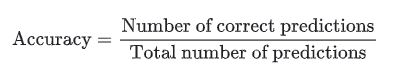

In [ ]:
network.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

**categorical_crossentropy** is the loss function that’s used as a feedback signal for learning the weight tensors, and which the training phase will attempt to minimize. You also know that this reduction of the loss happens via minibatch stochastic gradient descent. The exact rules governing a specific use of gradient descent are defined by the **rmsprop optimizer** passed as the first argument.

In [ ]:
#We also need to categorically encode the labels
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
#one-hot encoding example
from numpy import argmax
# define example
data = [1, 3, 2, 0, 3, 2, 2, 1, 0, 1]
print(data)
# one hot encode
encoded = to_categorical(data)
print(encoded)

[1, 3, 2, 0, 3, 2, 2, 1, 0, 1]
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


##Training

model.fit(input_tensor, output_tensor, epochs=10, batch_size=128,)

In [ ]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 11ms/step - loss: 0.2562 - accuracy: 0.9271
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.1026 - accuracy: 0.9705
Epoch 3/5
469/469 [==============================] - 5s 12ms/step - loss: 0.0688 - accuracy: 0.9790
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0500 - accuracy: 0.9847
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0379 - accuracy: 0.9883


**When you call fit:** the network will start to iterate on the training data in mini-batches of 128 samples, 5 times over (each iteration over all the training data is called an epoch). 

At each iteration, the network will compute the gradients of the weights with regard to the loss on the batch, and update the weights accordingly. After these 5 epochs, the network will have performed 2,345 gradient updates (469 per epoch), and the loss of the network will be sufficiently low that the network will be capable of classifying handwritten digits with high accuracy.

##Evaluation

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0726 - accuracy: 0.9789
test_acc: 0.9789000153541565


This gap between training accuracy and test accuracy is an example of
overfitting: the fact that machine-learning models tend to perform worse on new data than on their training data.

#**Classification Exercise with Fashion MNIST Dataset** : 
- Load the Fashion MNIST Dataset
- Check the shapes for x_train, y_train, x_test, y_test
- Plot one example from training data
- Reshape it and scale it to the [0,1] x_train and x_test
- Create the model
- Compile the model
- One hot encode target values y_train and y_test (using to_categorical) 
- Train and Evaluate according to test data.

In [ ]:
#Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
#Check the shapes
print('X train=%s y train=%s' % (x_train.shape,y_train.shape))
print('X test=%s y test=%s' % (x_test.shape,y_test.shape))

X train=(60000, 28, 28) y train=(60000,)
X test=(10000, 28, 28) y test=(10000,)


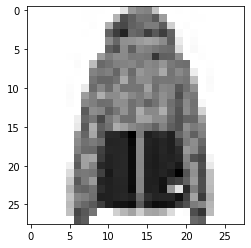

In [ ]:
#Plot the one image from training data
example = x_train[22]

plt.imshow(example, cmap=plt.cm.binary)
plt.show()

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way.

In [ ]:
#Reshape and scaling images (x_train,x_test)
x_train = x_train.reshape((60000, 28 * 28))
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28))
x_test = x_test.astype('float32') / 255

In [ ]:
#Creating a model
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
#Compilation 
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [ ]:
#We also need to categorically encode the labels 
# to one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#Train the model
model.fit(x_train,y_train, epochs=5,batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 11ms/step - loss: 0.5598 - accuracy: 0.7997
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.3795 - accuracy: 0.8608
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.3368 - accuracy: 0.8757
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.3118 - accuracy: 0.8852
Epoch 5/5
469/469 [==============================] - 5s 11ms/step - loss: 0.2918 - accuracy: 0.8925


In [ ]:
#Evalaute the model
test_loss2, test_acc2 = model.evaluate(x_test,y_test)


313/313 [==============================] - 1s 3ms/step - loss: 0.3582 - accuracy: 0.8738


In [ ]:
test_loss2

0.3581920564174652

In [ ]:
test_acc2

0.8737999796867371